## Autoencoders

Author: Calvin Chan

### Introduction

In this notebook, we will go through using autoencoders to see if it can reconstruct our signals. Upon successful reconstruction, it means that the neural network is able to capture features of our data. Throughout this notebook, we will only consider the 100 Hz signals.

### Table of Contents
- [Data Import](#import)
- [Autoencoder](#encoder)
- [Model Evaluation](#evaluation)

Let's import our required packages again.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import load_functions as f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import random as tf_random
from tensorflow import keras
from tensorflow.keras import layers

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

%autosave 300

Autosaving every 300 seconds


<a id='import'></a>
### Full Data Import 

We will import our full data looking at **low sampling frequency** using our `load_functions.py`.

In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [4]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

We need to preprocess our data again, this includes denoising our signals using `ecg_cleaning.py`.

In [5]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

<a id='encoder'></a>
### Autoencoder

Now that we have our signals, we can use autoencoders. Essentially the goal of autoencoders is for the model to reconstruct our signal after having learned a limited amount of features. If the model is able to do so, it means that it was able to learn those features that are deemed most important for our data. 

To start off, we need to label encode our data again using `LabelEncoder`. 

In [6]:
# Label Encode y data

# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

print(label.classes_)

# Transform target column 
y = label.transform(y)

["['CD', 'MI']" "['CD', 'NORM']" "['CD', 'STTC']" "['CD']" "['HYP']"
 "['MI']" "['NORM']" "['STTC', 'HYP']" "['STTC', 'MI']" "['STTC']"]


We define the same list of unique target names for plotting. 

In [7]:
# Target names
names = ["['NORM']", 
         "['STTC']", 
         "['MI']", 
         "['CD']", 
         "['HYP']", 
         "['CD', 'MI']", 
         "['STTC', 'HYP']", 
         "['CD', 'STTC']", 
         "['STTC', 'MI']", 
         "['CD', 'NORM']"]

In [8]:
# Label encode them 
name_label = label.transform(names)

In [9]:
print(name_label)

[6 9 5 3 4 0 7 2 8 1]


Splitting our data into training and validation set.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000), (12541,))

In [11]:
X_val.shape, y_val.shape

((3136, 1000), (3136,))

We can plot two sample signals for each target class for our ECGs. 

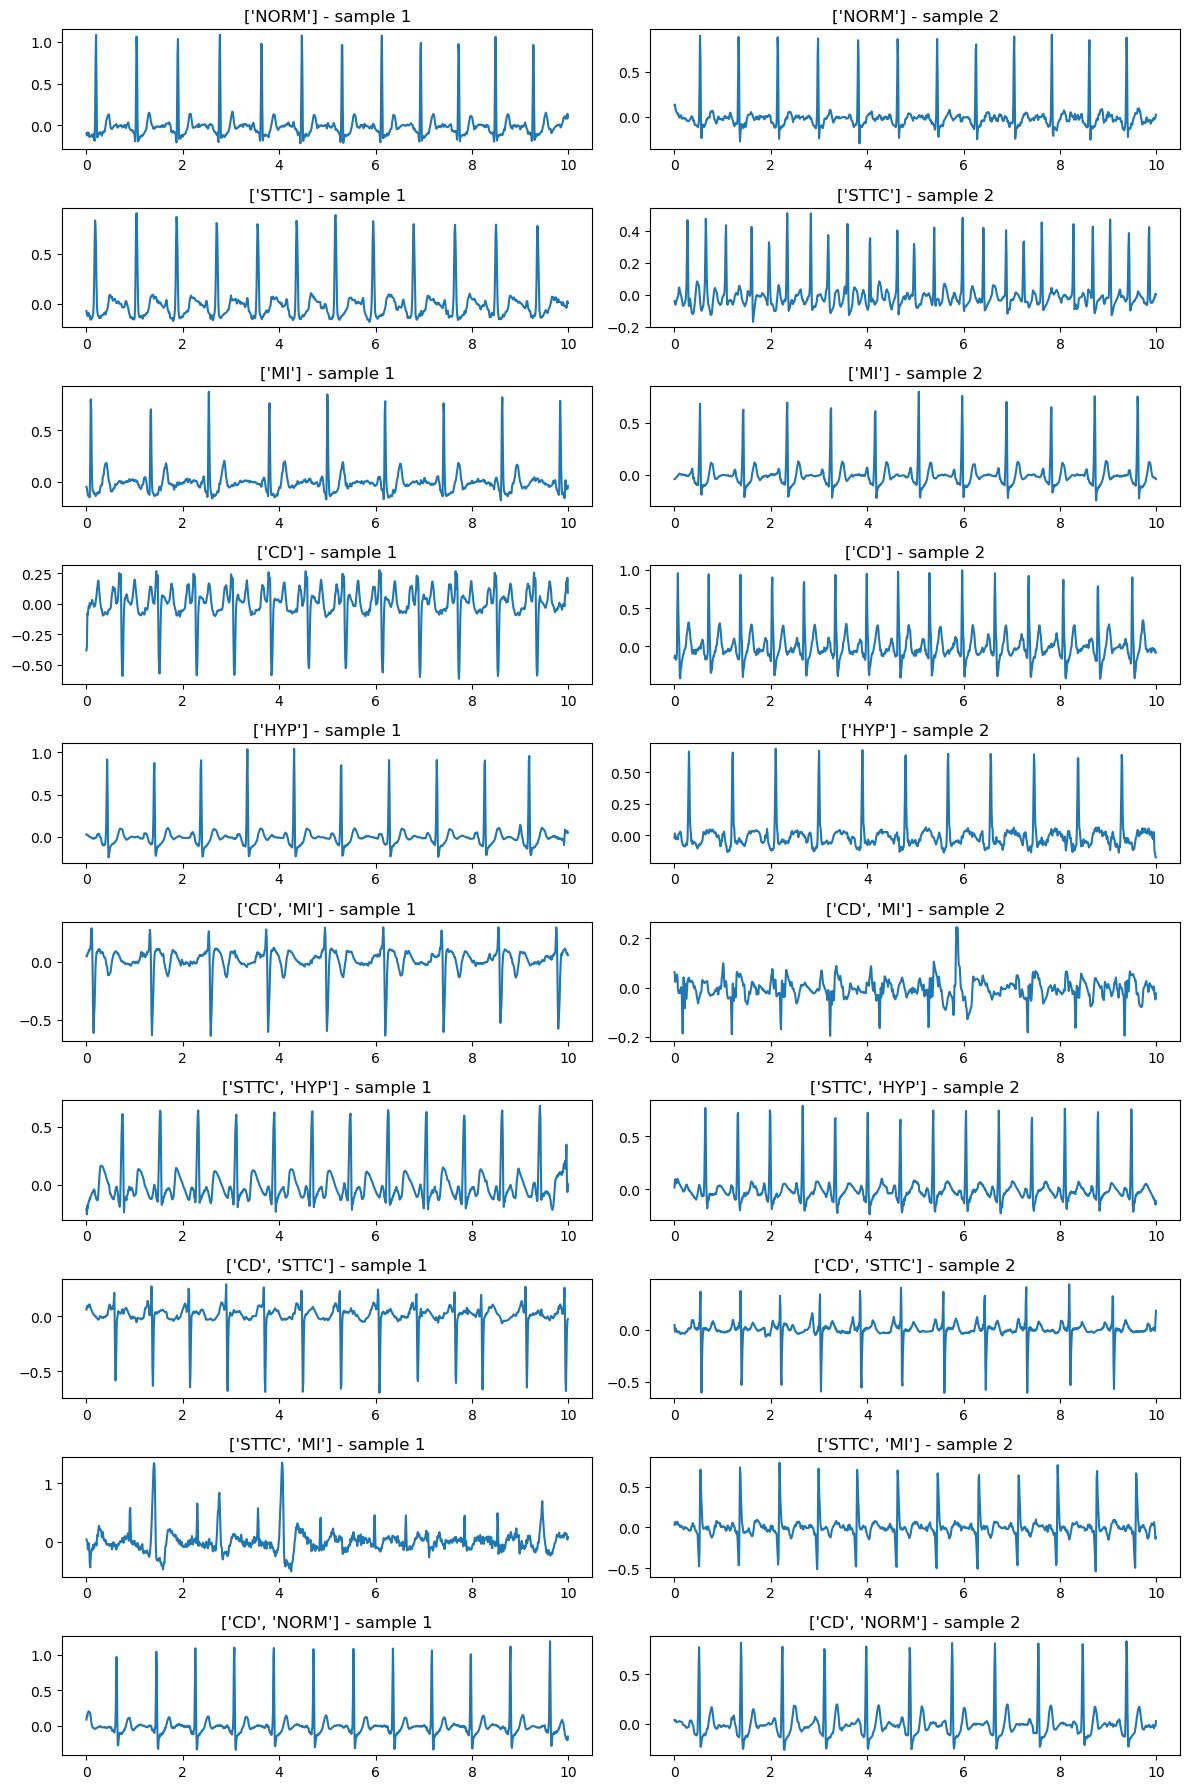

In [12]:
# Plot our sample signals first
fig, ax = plt.subplots(figsize=(12,18), nrows=10, ncols=2)

for i in range(len(names)):

    ax[i,0].plot(time, X_train[y_train == name_label[i]][0])
    ax[i,1].plot(time, X_train[y_train == name_label[i]][1])
    ax[i,0].set_title(f"{names[i]} - sample 1")
    ax[i,1].set_title(f"{names[i]} - sample 2")

fig.tight_layout()

Now we can create our fully-connected neural network. 

In [13]:
# Instantiate neural network
model = keras.Sequential()

# Add encoder part 
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(24, activation='relu'))

# Add decoder
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1000, activation=None))

# Compiling our model
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()]
)

# train our model
history = model.fit(X_train, X_train, 
                    validation_data=(X_val, X_val), 
                    epochs=50, 
                    verbose=2)

2024-04-18 13:31:51.717665: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
392/392 - 3s - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - 3s/epoch - 6ms/step
Epoch 2/50
392/392 - 1s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - 1s/epoch - 3ms/step
Epoch 3/50
392/392 - 1s - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - 1s/epoch - 3ms/step
Epoch 4/50
392/392 - 1s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - 1s/epoch - 3ms/step
Epoch 5/50
392/392 - 1s - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - 1s/epoch - 3ms/step
Epoch 6/50
392/392 - 1s - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - 1s/epoch - 3ms/step
Epoch 7/50
392/392 - 1s - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - 1s/epoch - 3ms/step
Epoch 

Notice how we have a bottle neck, this is an inherit feature in autoencoders. By reducing the hidden layer to a really small amount of nodes, we force the model to learn only the importance features of our signals before it uses the features to reconstruct the signal. 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 64)                1600      
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 1000)              257000    
                                                                 
Total params: 549,504
Trainable params: 549,504
Non-trai

Our model is pretty big with a large number of trainable parameters. Let's evaluate our model.

<a id='evaluation'></a>
### Model Evaluation

Since our signal is being reconstructed and our metric of evaluation is with the Mean Squared Error (MSE), we can look at the reconstructed MSE. Looking at our training and validation loss, we see that overall validation does not seem to drop as much as training does. This means that there is slight overfitting happening. As training loss continues to go down, validation is still remaining its losses as the epochs go on. 

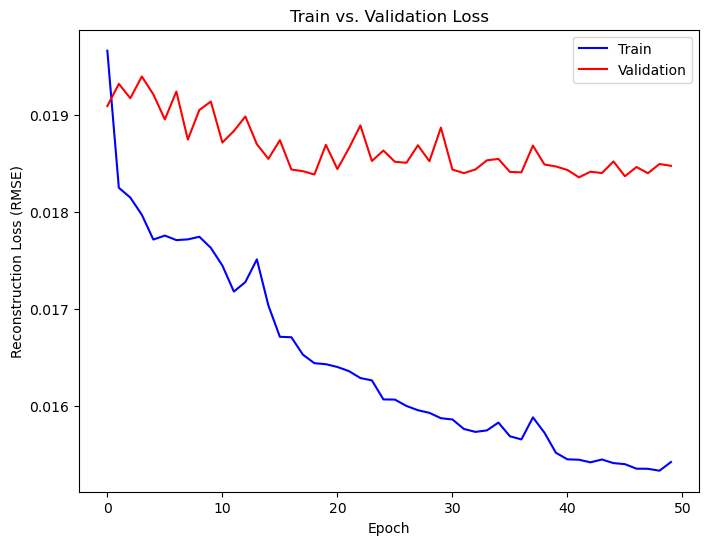

In [15]:
# MSE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_squared_error'], label="Train", c="b")
plt.plot(history.history['val_mean_squared_error'], label="Validation", c="r")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (RMSE)")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.show()

We can evaluate our model by asking it to reproduce our input signals. 

In [16]:
# Reconstruct signal 
X_train_reconstructed = model.predict(X_train.astype(np.float32))

Plotting the signals above the plots we had, we get the following. 

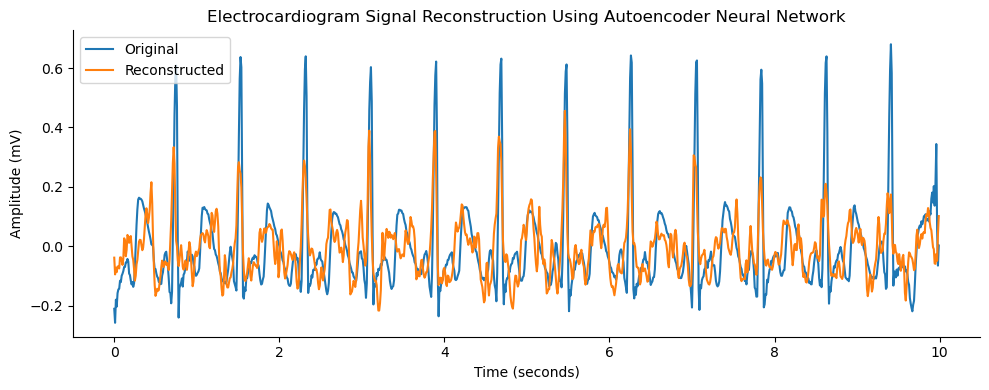

In [79]:
plt.figure(figsize=(10,4))
plt.plot(time, X_train[y_train == name_label[6]][0])
plt.plot(time, X_train_reconstructed[y_train == name_label[6]][0])
plt.legend(['Original', 'Reconstructed'])
plt.title("Electrocardiogram Signal Reconstruction Using Autoencoder Neural Network")
plt.xlabel('Time (seconds)')
plt.ylabel("Amplitude (mV)")
sns.despine()
plt.tight_layout()
plt.savefig('autoencoders_basecolor.jpg');

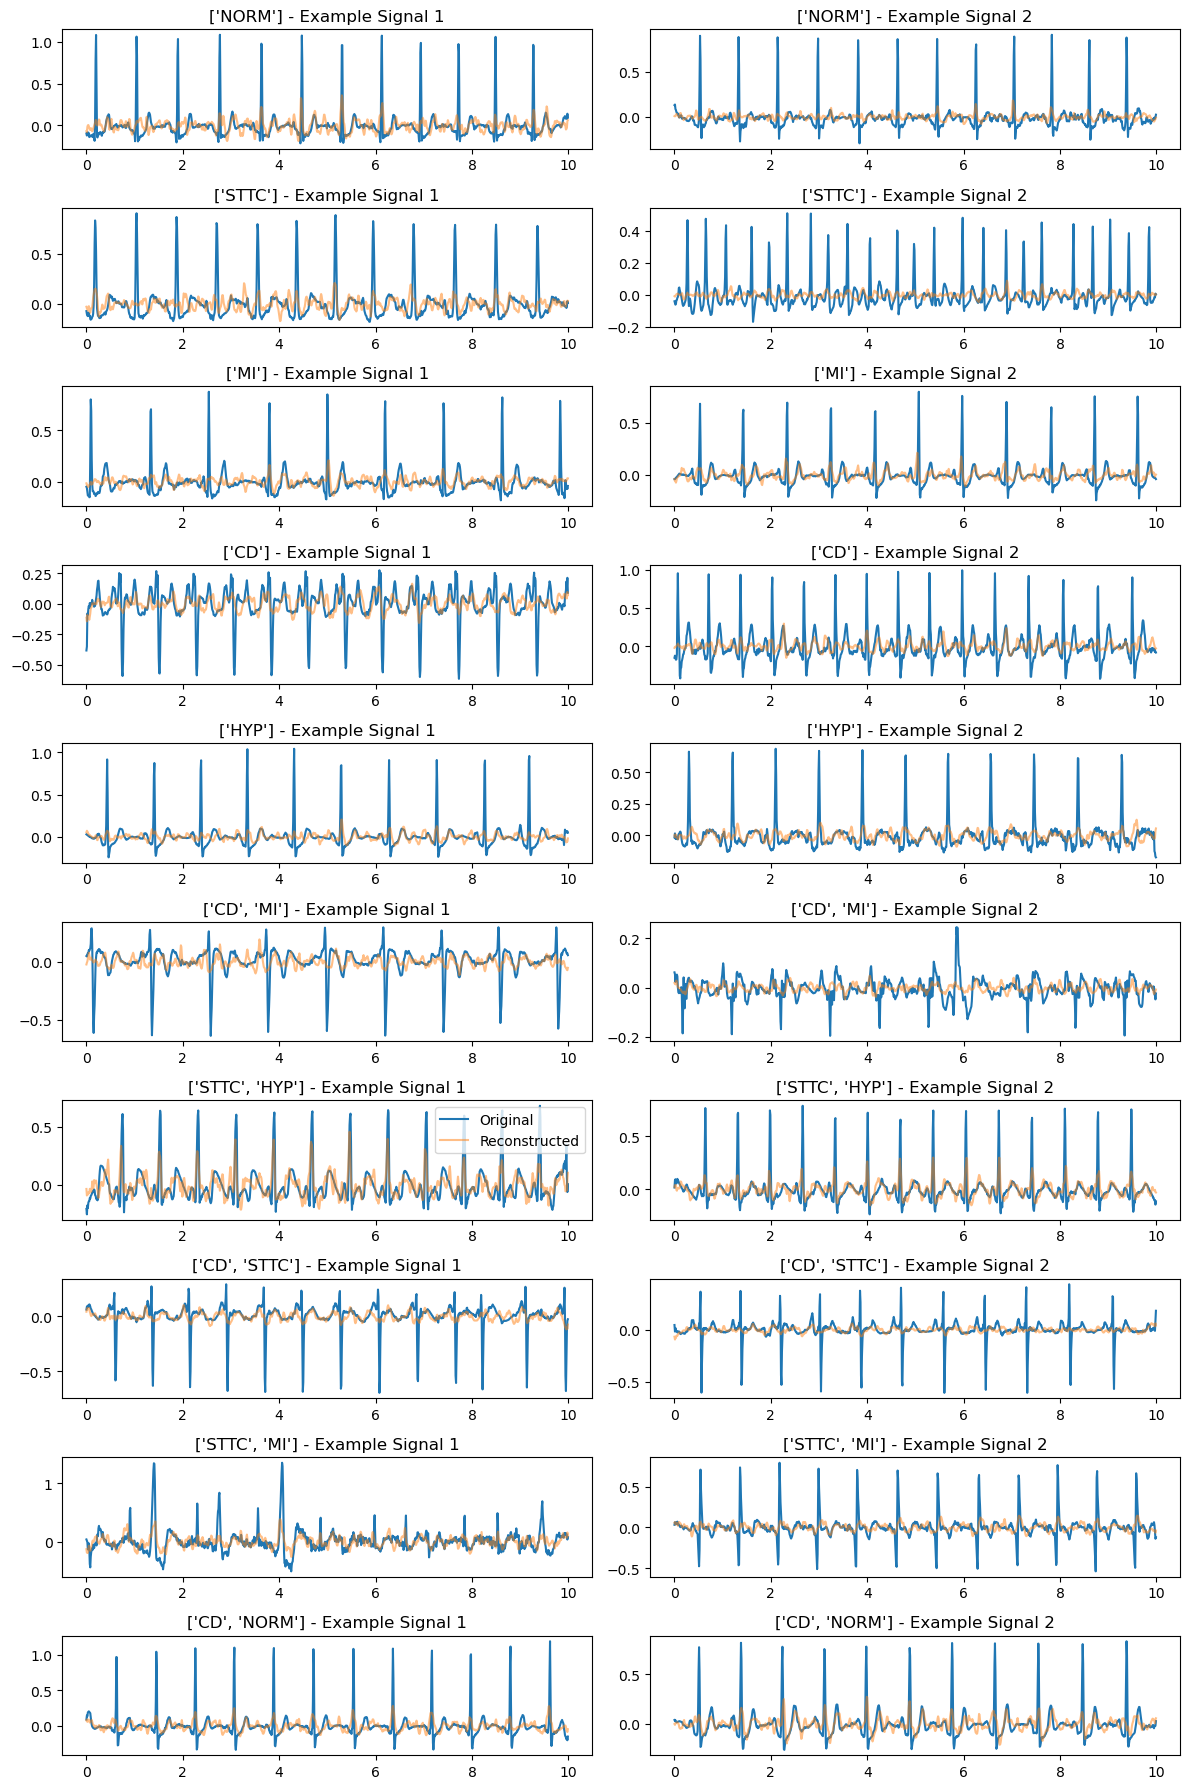

In [68]:
# Plot reconstructed signals
fig, ax = plt.subplots(figsize=(12,18), nrows=10, ncols=2)

for i in range(len(names)):

    ax[i,0].plot(time, X_train[y_train == name_label[i]][0])
    ax[i,0].plot(time, X_train_reconstructed[y_train == name_label[i]][0], alpha=0.5)
    ax[i,1].plot(time, X_train[y_train == name_label[i]][1])
    ax[i,1].plot(time, X_train_reconstructed[y_train == name_label[i]][1], alpha=0.5)
    ax[i,0].set_title(f"{names[i]} - Example Signal 1")
    ax[i,1].set_title(f"{names[i]} - Example Signal 2")

ax[6,0].legend(['Original', 'Reconstructed'])
fig.tight_layout()

From the graphs above, we see that the model does not capture all of the important features in our signal. As such, it is unable to predict accurately our input signals. We can evaluate our model more by looking at the errors in the reconstructed signal through a box plot.

In [18]:
# What is the biggest difference between input and output over the 1000 time-steps
reconstruction_error = abs(X_train - X_train_reconstructed).max(axis=1)

In [39]:
import ast
y_labels = [ast.literal_eval(x) for x in label.inverse_transform(y_train)]
y_labels

[['NORM'],
 ['MI'],
 ['STTC'],
 ['STTC', 'HYP'],
 ['NORM'],
 ['CD'],
 ['CD'],
 ['NORM'],
 ['NORM'],
 ['STTC', 'MI'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD', 'STTC'],
 ['NORM'],
 ['MI'],
 ['CD'],
 ['NORM'],
 ['NORM'],
 ['STTC', 'HYP'],
 ['CD'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['STTC'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['STTC'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['STTC'],
 ['CD', 'STTC'],
 ['NORM'],
 ['HYP'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD'],
 ['CD'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 ['MI'],
 ['MI'],
 ['NORM'],
 ['NORM'],
 ['CD'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['STTC'],
 ['CD'],
 ['CD', 'MI'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['STTC', 'MI'],
 ['CD', 'NORM'],
 ['NORM'],
 ['CD', 'STTC'],
 ['CD'],
 ['HYP'],
 ['NORM'],
 ['STTC', 'HYP'],
 ['STTC'],
 ['MI'],
 ['STTC'],
 ['NORM'],
 ['STTC'],
 ['NORM'],
 ['NORM'],
 ['NORM'],
 ['CD', 'STTC'],
 ['NORM'],
 ['STTC', 'HYP'],
 ['CD'],
 ['NORM'],
 ['

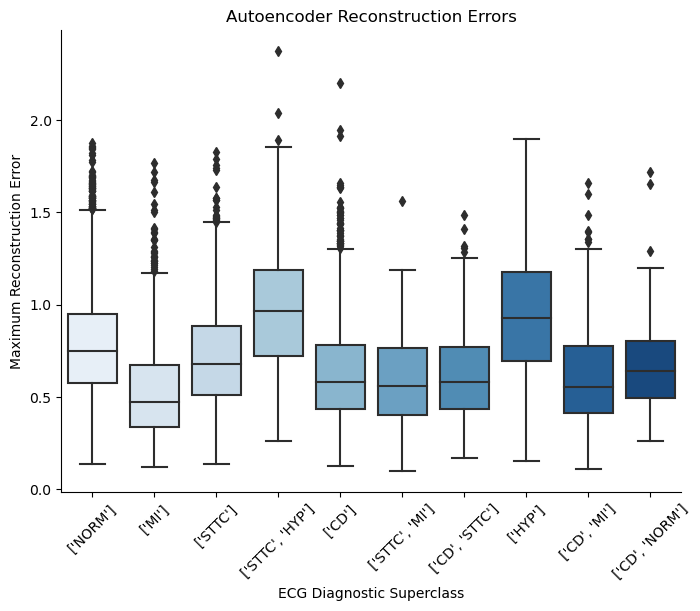

In [78]:
# Maximum reconstructed error
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_error, x=label.inverse_transform(y_train), palette='Blues')
sns.despine()
plt.title("Autoencoder Reconstruction Errors")
plt.xlabel("ECG Diagnostic Superclass")
plt.ylabel("Maximum Reconstruction Error")
plt.xticks(rotation=45)
# plt.ylim(0, 0.2)
plt.savefig('Autoencoder_errors.jpg')
plt.show()

Looking at this plot above, we see that there are a few classes that do not get classified properly, such as superclass 4 and 7. They tend to have greater reconstruction errors than the others. Notice how all of the classes actually have outliers. These are the sample points our reconstructed signal could not hit. 

Similarly, we can also look at the mean reconstructed error. 

In [ ]:
# Mean reconstructed error
reconstruction_error = abs(X_train - X_train_reconstructed).mean(axis=1)

In [ ]:
# Mean error plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_error, x=y_train)
plt.title("Reconstruction errors")
plt.xlabel("Diagnostic superclass")
plt.ylabel("Mean Reconstruction Error")
#plt.ylim(0, 1.5)
plt.show()

This plot almost shows the same results as the previous one, where superclass 4 and 7 have the biggest error, most likely being least classified. 

From both boxplots, we see that it is difficult to distinguish between normal ECGs and the others resulting in poor reconstruction of the signal. 

### Next steps

As an experiment to finding the best model, we found that autoencoders thus far seem to have a little trouble with picking up the most important features in our ECG signals. This allows us to explore other types of neural networks. Next, we will look into Recurrent Neural Networks as they have been known to be good for time series data like ours. This can be found in notebook `5 - Recurrent Neural Networks`.